# Analysis of early termination data

Data produced from the `_run_simulations` method in [`PoincareEnsemble.ipynb`](PoincareEnsemble.ipynb)

- We are numerically integrating double pendulum simulations with release angles $\theta_1, \theta_2 \in [0, \pi]$

- A termination event for the integration is defined as either of the angles reaching $10 * \tau$ (10 complete circles)

The initial conditions are selected using a biased Monte Carlo ensemble method. At the moment we generate $10^3$ initial conditions but will push to $10^4$ and beyond after runtime optimisations. Roughly 50% of simulations terminated early, of these, roughly 25% terminated before 1 minute (I can live with termination after 1 minute)

##### The aim of this analysis is to write filters to excluded certain angle combinations to optimise early termination (I can live with 10% terminating before 1 minute)

I need to find patterns in the below numerical data to exclude certain $\theta_1, \theta_2$ combinations in my biased sampling

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [3]:
#df = pd.read_csv('termination_data/older_data/raw_termination_data_three.csv')
df = pd.read_csv('termination_data/raw_termination_data.csv')
df.head()

,initial_conditions,termination_time,termination_reason
0,"(np.float64(0.5235987755982988), np.float64(2....",77.926935,Large deviation
1,"(np.float64(0.5235987755982988), np.float64(2....",114.055857,Large deviation
2,"(np.float64(0.7853981633974483), np.float64(2....",82.851640,Large deviation
3,"(np.float64(0.7853981633974483), np.float64(2....",105.052103,Large deviation
4,"(np.float64(1.0471975511965976), np.float64(2....",62.994258,Large deviation


In [4]:
unique_reasons = df['termination_reason'].unique()
print(unique_reasons)

['Large deviation']


In [5]:
def extract_floats(condition):
    # extract values wrapped in np.float64
    match = re.findall(r'np\.float64\((.*?)\)', condition)
    if match:
        return tuple(map(float, match))
    else:
        # If no np.float64 wrapping, split the tuple and convert to floats
        stripped = condition.strip("()")
        parts = [x.strip() for x in stripped.split(',')]
        return float(parts[0]), float(parts[1])

# Apply the function and split the result into two new columns
df[['theta1_radians', 'theta2_radians']] = df['initial_conditions'].apply(lambda x: extract_floats(x)).apply(pd.Series)

In [6]:
# Convert radians to degrees and round to 2 decimal places
df['theta1_degrees'] = df['theta1_radians'].apply(lambda x: round(np.degrees(x), 2))
df['theta2_degrees'] = df['theta2_radians'].apply(lambda x: round(np.degrees(x), 2))

df.drop(columns=['initial_conditions', 'termination_reason'], inplace=True)
df = df.sort_values(by='termination_time')

In [7]:
df.head(10)

,termination_time,theta1_radians,theta2_radians,theta1_degrees,theta2_degrees
195,25.354093,2.069390,1.565130,118.57,89.68
228,27.913603,1.907240,1.717500,109.28,98.41
261,28.570911,2.302160,1.703490,131.90,97.60
19,29.083622,2.617994,1.047198,150.00,60.00
232,29.875087,2.375560,1.091930,136.11,62.56
62,30.296723,2.069350,0.511870,118.57,29.33
230,30.872344,2.183860,1.270200,125.13,72.78
246,32.772462,2.472130,0.990880,141.64,56.77
259,33.585155,2.569150,0.670770,147.20,38.43
196,33.722811,1.744730,2.259440,99.97,129.46


In [8]:
df.describe()

,termination_time,theta1_radians,theta2_radians,theta1_degrees,theta2_degrees
count,372.000000,372.000000,372.000000,372.000000,372.000000
mean,78.184037,1.827337,1.551167,104.698602,88.875269
std,21.890958,0.520790,0.874444,29.839130,50.101899
min,25.354093,0.143700,0.004920,8.230000,0.280000
25%,63.140261,1.480498,0.811033,84.825000,46.465000
50%,79.430731,1.919135,1.557235,109.960000,89.225000
75%,92.616334,2.211000,2.299523,126.677500,131.755000
max,119.884323,2.617994,3.132560,150.000000,179.480000


In [9]:
# Output the DataFrame to a CSV file
#df.to_csv("clean_termination_data.csv", index=False)

----
&nbsp;
#### Filtering for termination time < 60 seconds

In [10]:
filtered_df = df[df['termination_time'] < 60]
filtered_df = filtered_df[['termination_time', 'theta1_degrees', 'theta2_degrees']]
print(f"Dataframe shape: {filtered_df.shape}")

Dataframe shape: (81, 3)


In [11]:
correlation_matrix = filtered_df.corr()
correlation_matrix

,termination_time,theta1_degrees,theta2_degrees
termination_time,1.000000,-0.047000,0.070164
theta1_degrees,-0.047000,1.000000,-0.715351
theta2_degrees,0.070164,-0.715351,1.000000


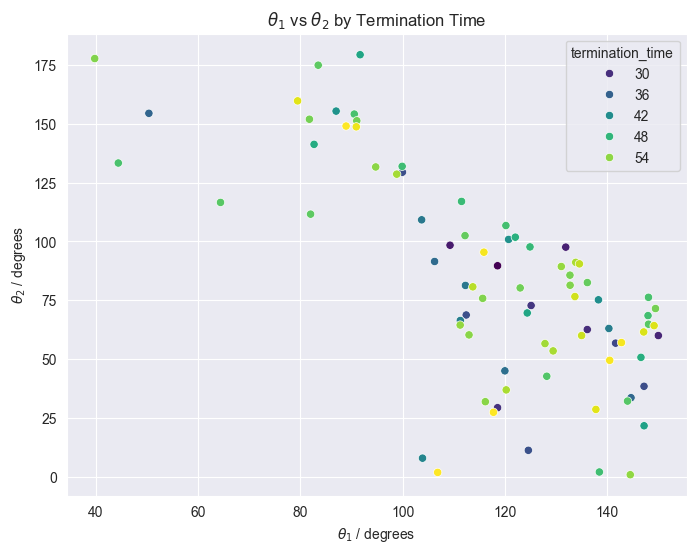

In [12]:
# Scatter plot of theta1 vs theta2 colored by termination_time
plt.figure(figsize=(8, 6))
sns.scatterplot(x='theta1_degrees', y='theta2_degrees', hue='termination_time', 
                palette='viridis', data=filtered_df)
plt.title(r'$\theta_1$ vs $\theta_2$ by Termination Time')
plt.xlabel(r'$\theta_1$ / degrees')
plt.ylabel(r'$\theta_2$ / degrees')
plt.show()

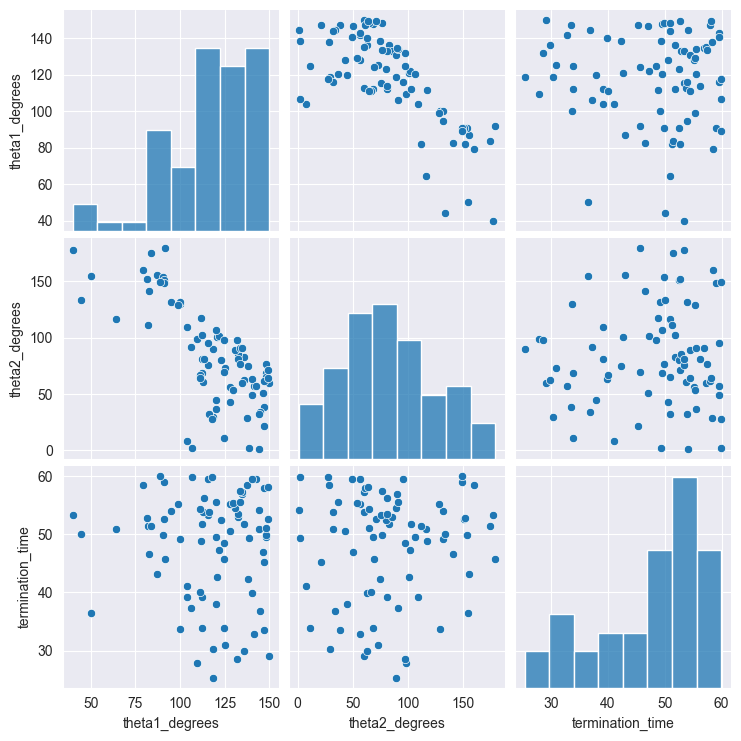

In [13]:
# Pair plot of theta1, theta2, and termination_time
sns.pairplot(filtered_df[['theta1_degrees', 'theta2_degrees', 'termination_time']])
plt.show()

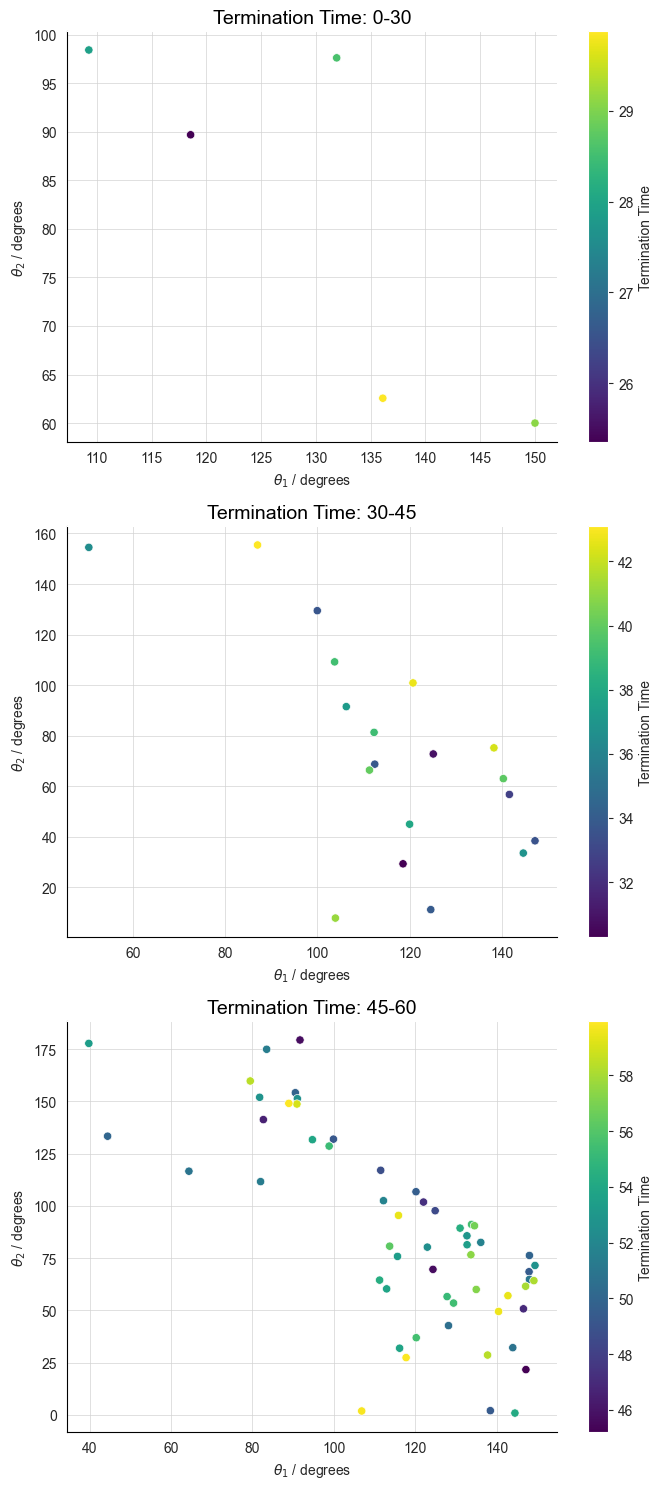

In [14]:
custom_bins = [0, 30, 45, 60]
bin_labels = ['0-30', '30-45', '45-60']

filtered_df['termination_bin'] = pd.cut(filtered_df['termination_time'], bins=custom_bins, labels=bin_labels, include_lowest=True)
fig, axes = plt.subplots(3, 1, figsize=(7, 15))  # 1x3 grid for 3 bins

# Iterate through each bin and create a scatter plot in its corresponding subplot
for i, (bin_name, group) in enumerate(filtered_df.groupby('termination_bin', observed=True)):
    ax = axes[i] 
    norm = plt.Normalize(group['termination_time'].min(), group['termination_time'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Necessary for ScalarMappable
    sns.scatterplot(data=group, x='theta1_degrees', y='theta2_degrees', 
                    hue='termination_time', ax=ax, palette='viridis', legend=False)
    
    # Set the title and labels
    ax.set_title(f'Termination Time: {bin_name}', fontsize=14, color='black')
    ax.set_xlabel(r'$\theta_1$ / degrees')
    ax.set_ylabel(r'$\theta_2$ / degrees')
    
    # Customize the grid and axes colors
    ax.set_facecolor('white') 
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='lightgrey')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Termination Time')

plt.tight_layout()
plt.show()

----
&nbsp;
#### Identifying Outliers

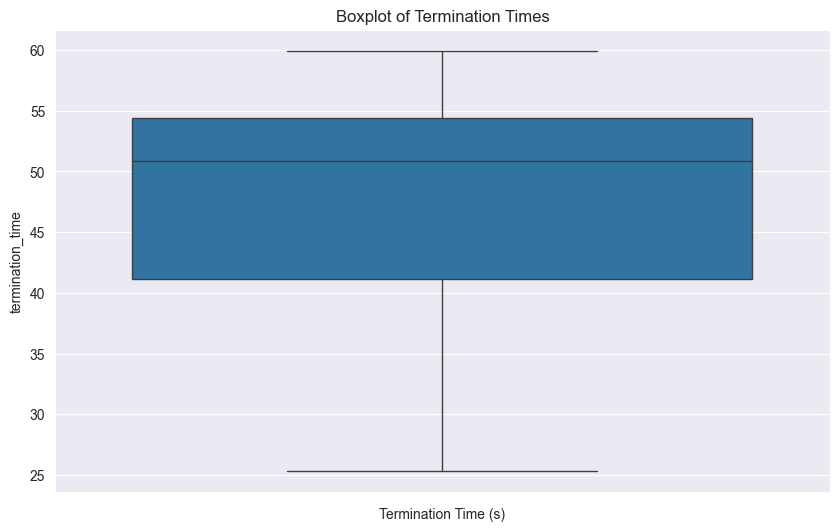

In [15]:
# Visual Inspection with a Boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(filtered_df['termination_time'])
plt.title('Boxplot of Termination Times')
plt.xlabel('Termination Time (s)')
plt.show()

In [16]:
# Identify outliers using the Z-score method
filtered_df['z_score'] = np.abs(zscore(filtered_df['termination_time']))

# Set a threshold for Z-score, usually 3 or above indicates an outlier
outliers_z = filtered_df[filtered_df['z_score'] > 1.5]

In [17]:
print(outliers_z.shape)
print(outliers_z['termination_bin'].unique())
print(f"Max termination time: {outliers_z['termination_time'].max()}\n"
      f"Min termination time: {outliers_z['termination_time'].min()}")
outliers_z.head()

(12, 5)
['0-30', '30-45']
Categories (3, object): ['0-30' < '30-45' < '45-60']
Max termination time: 33.908641129237864
Min termination time: 25.35409292807096


,termination_time,theta1_degrees,theta2_degrees,termination_bin,z_score
195,25.354093,118.57,89.68,0-30,2.423036
228,27.913603,109.28,98.41,0-30,2.147975
261,28.570911,131.90,97.60,0-30,2.077337
19,29.083622,150.00,60.00,0-30,2.022237
232,29.875087,136.11,62.56,0-30,1.937182


In [18]:
# Calculate the lower quartile (Q1)
Q1 = filtered_df['termination_time'].quantile(0.25)

# Filter the data to include only those with termination times <= Q1
lower_quartile_df = filtered_df[filtered_df['termination_time'] <= Q1]

# Summary of the filtered data
print("Summary of data in the lower quartile:")
lower_quartile_df.describe()

Summary of data in the lower quartile:


,termination_time,theta1_degrees,theta2_degrees,z_score
count,21.000000,21.000000,21.000000,21.000000
mean,34.173830,119.441429,69.875238,1.475212
std,4.592730,22.180711,36.796271,0.493564
min,25.354093,50.410000,7.870000,0.730527
25%,30.296723,109.280000,45.000000,1.073636
50%,33.831955,118.570000,66.400000,1.511952
75%,37.910593,136.110000,91.500000,1.891870
max,41.103302,150.000000,154.500000,2.423036


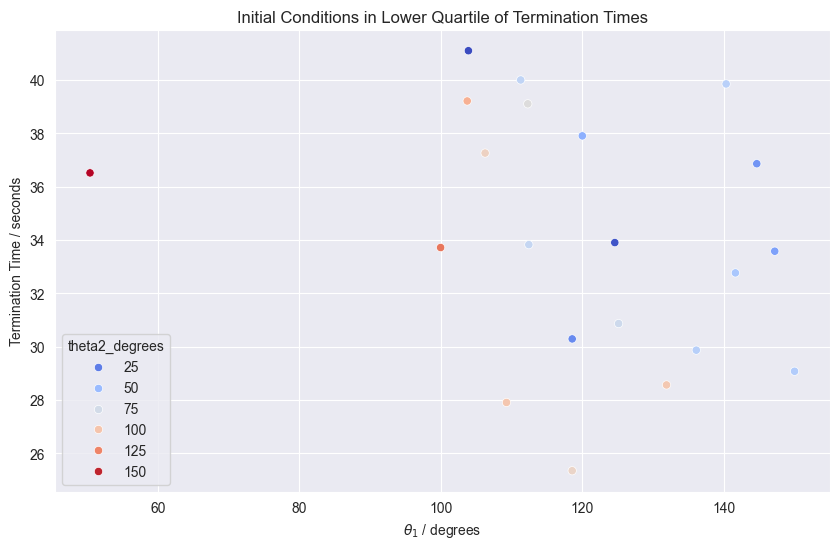

In [19]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=lower_quartile_df, x='theta1_degrees', y='termination_time', hue='theta2_degrees', palette='coolwarm')
plt.title('Initial Conditions in Lower Quartile of Termination Times')
plt.xlabel(r'$\theta_1$ / degrees')
plt.ylabel('Termination Time / seconds')
plt.show()

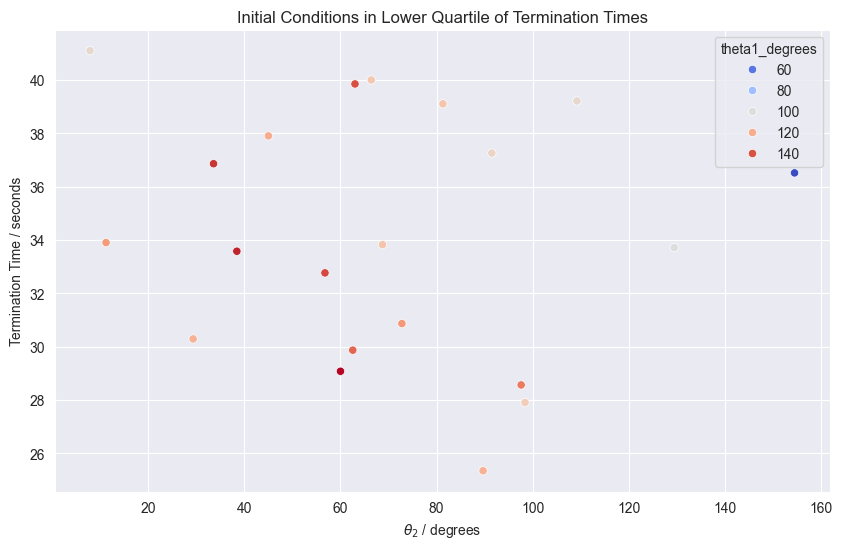

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=lower_quartile_df, x='theta2_degrees', y='termination_time', hue='theta1_degrees', palette='coolwarm')
plt.title('Initial Conditions in Lower Quartile of Termination Times')
plt.xlabel(r'$\theta_2$ / degrees')
plt.ylabel('Termination Time / seconds')
plt.show()

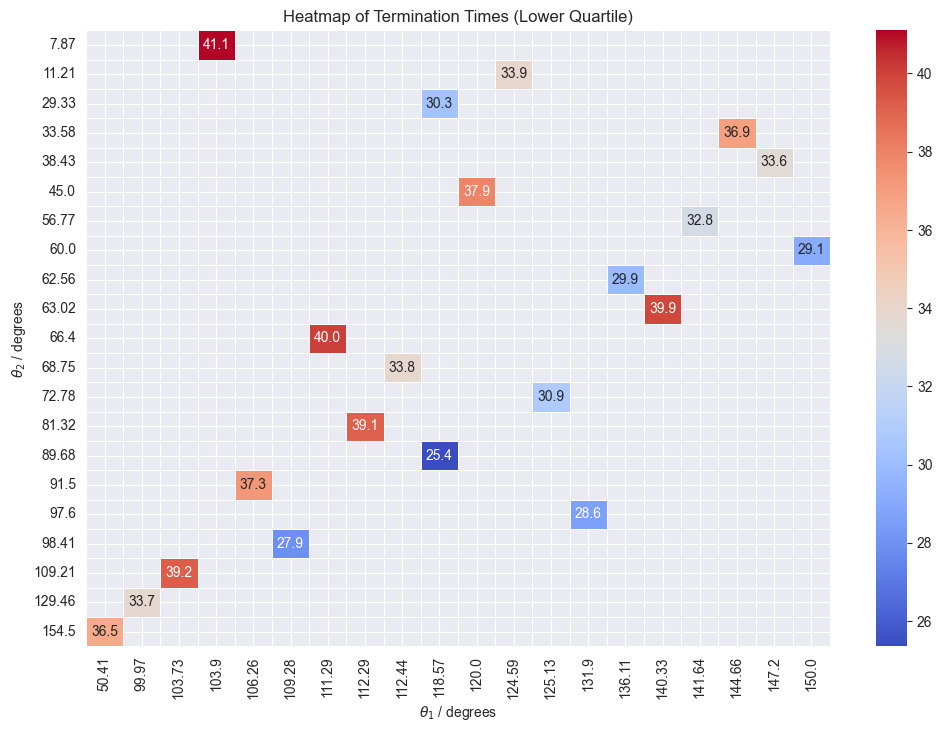

In [21]:
# Create a pivot table for the heatmap, with theta1_degrees on the x-axis, theta2_degrees on the y-axis,
# and the average termination_time as the values.
heatmap_data = lower_quartile_df.pivot_table(index='theta2_degrees', columns='theta1_degrees', values='termination_time', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title('Heatmap of Termination Times (Lower Quartile)')
plt.xlabel(r'$\theta_1$ / degrees')
plt.ylabel(r'$\theta_2$ / degrees')
plt.show()

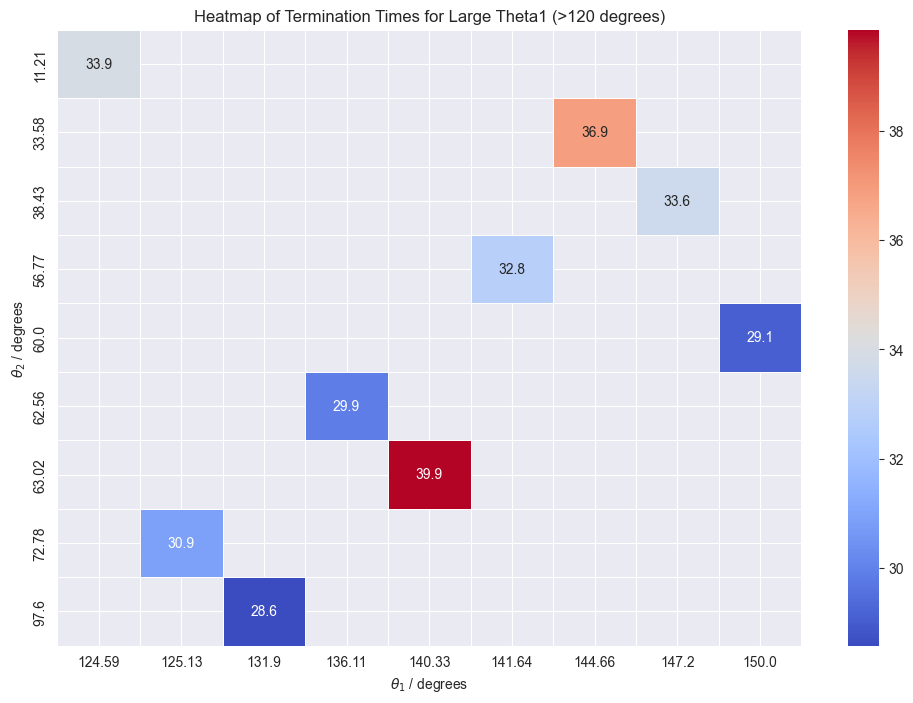

In [22]:
# Define the threshold for large theta1 (e.g., greater than 120 degrees)
theta1_threshold = 120

# Filter the dataframe for theta1 values greater than the threshold
large_theta1_df = lower_quartile_df[lower_quartile_df['theta1_degrees'] > theta1_threshold]

# Create a pivot table for the heatmap, with theta1_degrees on the x-axis, theta2_degrees on the y-axis,
# and the average termination_time as the values.
heatmap_data_large_theta1 = large_theta1_df.pivot_table(index='theta2_degrees', columns='theta1_degrees', values='termination_time', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_large_theta1, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title(f'Heatmap of Termination Times for Large Theta1 (>{theta1_threshold} degrees)')
plt.xlabel(r'$\theta_1$ / degrees')
plt.ylabel(r'$\theta_2$ / degrees')
plt.show()

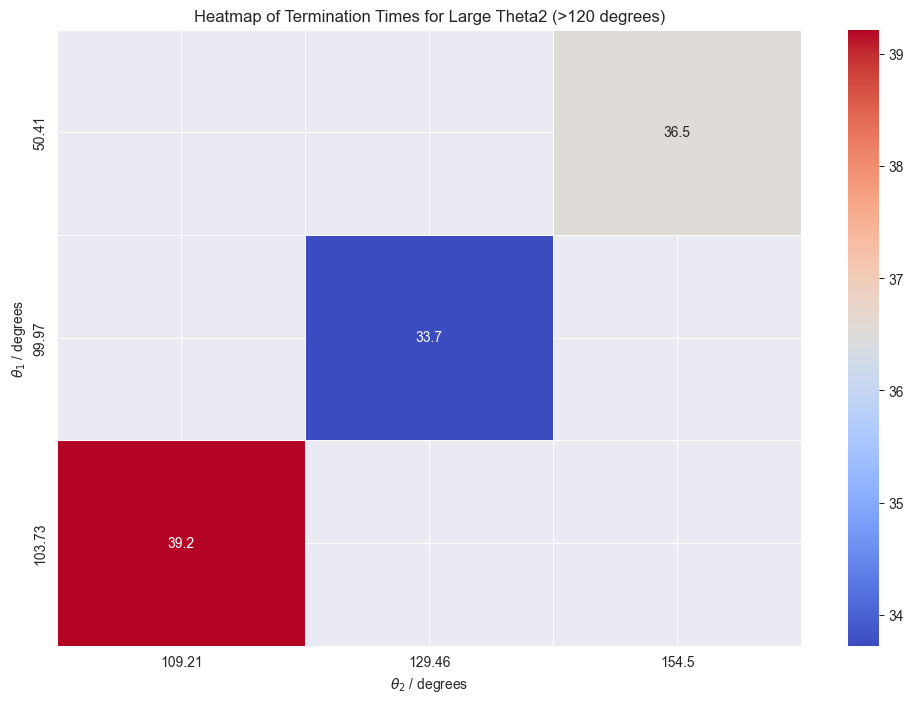

In [23]:
# Define the threshold for large theta2
theta2_threshold = 100

# Filter the dataframe for theta1 values greater than the threshold
large_theta2_df = lower_quartile_df[lower_quartile_df['theta2_degrees'] > theta2_threshold]

# Create a pivot table for the heatmap, with theta1_degrees on the x-axis, theta2_degrees on the y-axis,
# and the average termination_time as the values.
heatmap_data_large_theta2 = large_theta2_df.pivot_table(index='theta1_degrees', columns='theta2_degrees', values='termination_time', aggfunc='mean')

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_large_theta2, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)
plt.title(f'Heatmap of Termination Times for Large Theta2 (>{theta1_threshold} degrees)')
plt.xlabel(r'$\theta_2$ / degrees')
plt.ylabel(r'$\theta_1$ / degrees')
plt.show()

### Exclusions

1. From `raw_termination_data.csv`, $\theta_1$ should never be greater than $150^{\circ}$
2. From `raw_termination_data_two.csv`, if $\theta_2$ > $120^{\circ}$ then $\theta_1$ should never be greater than $100^{\circ}$

Changed 
```python
# Define an event to detect large deviations
def event_large_deviation(t, y):
    max_angle_limit = 15 * (2 * np.pi)   # Allow 15 loops - May need to be tweaked
    return max_angle_limit - max(np.abs(y[0]), np.abs(y[1]))
```
To angle limit = $15\tau$ and we are below 10% terminations less than 60 seconds